In [1]:
from preprocessing import parse_annotation,BatchGenerator
import numpy as np
from frontend import YOLO
from matplotlib import pyplot as plt


/home/jingwen/anaconda2/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
config=dict()
config["train"]=dict()
config["model"]=dict()
config["valid"]=dict()
config["valid"]["valid_times"]=1
config["train"]["train_annot_folder"]="RBC_datasets/Annotations/"
config["train"]["train_image_folder"]="RBC_datasets/JPEGImages/"
config["train"]["train_times"]=1
config["train"]["batch_size"]=32
config["train"]["learning_rate"]=1e-4
config["train"]["nb_epoch"]=50
config["train"]["warmup_batches"]=250
config["train"]["object_scale"]=5.0
config["train"]["no_object_scale"]=1.0
config["train"]["coord_scale"]=1.0
config["train"]["class_scale"]=1.0
config["model"]["labels"]=["RBC"]
config["model"]["input_size"]=416
config["model"]["max_box_per_img"]=10
config["model"]["anchors"]=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
config["model"]["architecture"]="Tiny Yolo"
config["model"]["grid_w"]=13
config["model"]["grid_h"]=13

weights_path="models/tiny_yolo_100.h5"

In [3]:
imgs,_=parse_annotation(config["train"]["train_annot_folder"],
                        config["train"]["train_image_folder"],
                        config["model"]["labels"]
                       )
split_idx=int(0.8*len(imgs))
np.random.shuffle(imgs)
train_imgs=imgs[:split_idx]
valid_imgs=imgs[split_idx:]
print(train_imgs[0])

{'height': 480, 'object': [{'ymax': 382, 'xmax': 336, 'xmin': 227, 'name': 'RBC', 'ymin': 276}, {'ymax': 175, 'xmax': 394, 'xmin': 285, 'name': 'RBC', 'ymin': 69}, {'ymax': 471, 'xmax': 456, 'xmin': 331, 'name': 'RBC', 'ymin': 361}, {'ymax': 372, 'xmax': 640, 'xmin': 555, 'name': 'RBC', 'ymin': 253}, {'ymax': 392, 'xmax': 540, 'xmin': 447, 'name': 'RBC', 'ymin': 291}, {'ymax': 168, 'xmax': 640, 'xmin': 547, 'name': 'RBC', 'ymin': 41}, {'ymax': 236, 'xmax': 612, 'xmin': 519, 'name': 'RBC', 'ymin': 135}, {'ymax': 278, 'xmax': 423, 'xmin': 346, 'name': 'RBC', 'ymin': 188}, {'ymax': 350, 'xmax': 439, 'xmin': 362, 'name': 'RBC', 'ymin': 260}, {'ymax': 82, 'xmax': 264, 'xmin': 185, 'name': 'RBC', 'ymin': 9}, {'ymax': 90, 'xmax': 152, 'xmin': 56, 'name': 'RBC', 'ymin': 17}, {'ymax': 55, 'xmax': 183, 'xmin': 90, 'name': 'RBC', 'ymin': 1}, {'ymax': 435, 'xmax': 213, 'xmin': 91, 'name': 'RBC', 'ymin': 335}, {'ymax': 480, 'xmax': 585, 'xmin': 461, 'name': 'RBC', 'ymin': 411}, {'ymax': 80, 'xmax':

[9.203125, 10.265625, 1.96875, 2.65625]
RBC_datasets/JPEGImages/BloodImage_00298.jpg


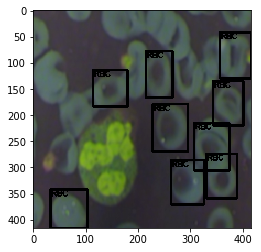

(416, 416, 3)
(13, 13, 5, 6)


In [4]:
generator_config={
        "IMAGE_H":config["model"]["input_size"],
        "IMAGE_W":config["model"]["input_size"],
        "GRID_H":config["model"]["grid_h"],
        "GRID_W":config["model"]["grid_w"],
        "BOX":5,
        "LABELS":config["model"]["labels"],
        "CLASS":len(config["model"]["labels"]),
        "ANCHORS":config["model"]["anchors"],
        "BATCH_SIZE":config["train"]["batch_size"],
        "TRUE_BOX_BUFFER":config["model"]["max_box_per_img"]
        }

generator=BatchGenerator(train_imgs,generator_config,norm=None)
[x,b],y=generator.__getitem__(0)
plt.imshow(x[0])
plt.show()
print(x[0].shape)
print(y[0].shape)

In [6]:
yolo=YOLO(architecture=config["model"]["architecture"],
            input_size=config["model"]["input_size"],
            labels=config["model"]["labels"],
            max_box_per_img=config["model"]["max_box_per_img"],
            anchors=config["model"]["anchors"])
yolo.load_weights(weights_path)
yolo.train(
      train_imgs,
      valid_imgs,
      config["train"]["train_times"],
      config["valid"]["valid_times"],
      config["train"]["nb_epoch"],
      config["train"]["learning_rate"],
      config["train"]["batch_size"],
      config["train"]["warmup_batches"],
      config["train"]["object_scale"],
      config["train"]["no_object_scale"],
      config["train"]["coord_scale"],
      config["train"]["class_scale"],train=False)

load weights from models/tiny_yolo_backend.h5


[4.609375, 10.65625, 2.03125, 2.375]
RBC_datasets/JPEGImages/BloodImage_00112.jpg


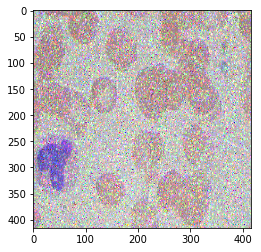

1/1 [==============================] - 0s 301ms/step
3.4197559356689453


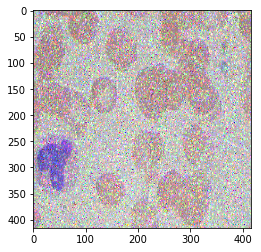

In [22]:
[test_x,test_b],test_y=yolo.compute_loss(train_imgs)
netout=yolo.model.predict([np.expand_dims(test_x,0),np.expand_dims(test_b,0)])[0]
from utils import decode_netout,draw_boxes
boxes=decode_netout(netout,0.52,0.2,config["model"]["anchors"],len(config["model"]["labels"]))
img=draw_boxes(boxes,test_x,config["model"]["labels"])
plt.imshow(img)
plt.show()